<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Физтех-Школа-Прикладной-математики-и-информатики-(ФПМИ)-МФТИ" data-toc-modified-id="Физтех-Школа-Прикладной-математики-и-информатики-(ФПМИ)-МФТИ-0.1"><strong>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</strong></a></span></li></ul></li><li><span><a href="#Journey-to-Springfield" data-toc-modified-id="Journey-to-Springfield-1">Journey to Springfield</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#requirements" data-toc-modified-id="requirements-1.0.1">requirements</a></span></li></ul></li></ul></li><li><span><a href="#imports" data-toc-modified-id="imports-2">imports</a></span></li><li><span><a href="#Define-model" data-toc-modified-id="Define-model-3">Define model</a></span></li><li><span><a href="#Train-/-val-dataset-and-dataloader" data-toc-modified-id="Train-/-val-dataset-and-dataloader-4">Train / val dataset and dataloader</a></span><ul class="toc-item"><li><span><a href="#Дисбаланс-классов" data-toc-modified-id="Дисбаланс-классов-4.1">Дисбаланс классов</a></span></li><li><span><a href="#Let's-see-pictures-from-train-dataset" data-toc-modified-id="Let's-see-pictures-from-train-dataset-4.2">Let's see pictures from train dataset</a></span></li></ul></li><li><span><a href="#Training-/-feature-extraction" data-toc-modified-id="Training-/-feature-extraction-5">Training / feature extraction</a></span></li><li><span><a href="#Fine-tuning" data-toc-modified-id="Fine-tuning-6">Fine tuning</a></span></li><li><span><a href="#Classification-report" data-toc-modified-id="Classification-report-7">Classification report</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-8">Prediction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Submit-на-Kaggle" data-toc-modified-id="Submit-на-Kaggle-8.0.1">Submit на Kaggle</a></span></li></ul></li></ul></li></ul></div>



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Journey to Springfield 


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### requirements

In [1]:
# !pip install -r requirements.txt

In [2]:
# google colab cell

# from google.colab import drive
# drive.mount('/content/gdrive/')

# from pathlib import Path
# p = Path('/content/gdrive/MyDrive/Colab_Notebooks/Simpsons/data')
# !ls $p

# imports

In [3]:
import pickle
import numpy as np
# from skimage import io
import pandas as pd
import os

from tqdm.notebook import trange, tqdm
from PIL import Image
from pathlib import Path
import shutil
import os 
import datetime 

import torch
from torchvision import transforms
# MODEL import

from torchvision.models import resnext101_32x8d
from torchvision.models import efficientnet_b4
# import torchsummary

# from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import compute_class_weight
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
# import albumentations as albu
# from albumentations.pytorch import ToTensorV2

import wandb
# wandb.login()

from collections import Counter, OrderedDict
import platform
from natsort import natsorted 
from matplotlib import colors, pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = "retina"


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from config import *
from func import *

# Define model

In [4]:
if CONFIG['DEBUG']:
    CONFIG['LOG_ENABLE'] = False


In [5]:
# MODEL = resnext101_32x8d(weights=CONFIG['WEIGHTS'])

MODEL = efficientnet_b4(weights=CONFIG['WEIGHTS'])
manual_seed(CONFIG['SEED'])


In [6]:
if CONFIG['LOG_ENABLE']:
    wandb.init(project=CONFIG['PROJECT_NAME'], name=f"{CONFIG['MODEL_NAME']}_{CONFIG['DESC']}")
    wandb.watch(MODEL)

wandb: Currently logged in as: ac1d. Use `wandb login --relogin` to force relogin


# Train / val dataset and dataloader

>>>>> total train and val files: 21194
>>>>> total test files: 991
>> Training on mps


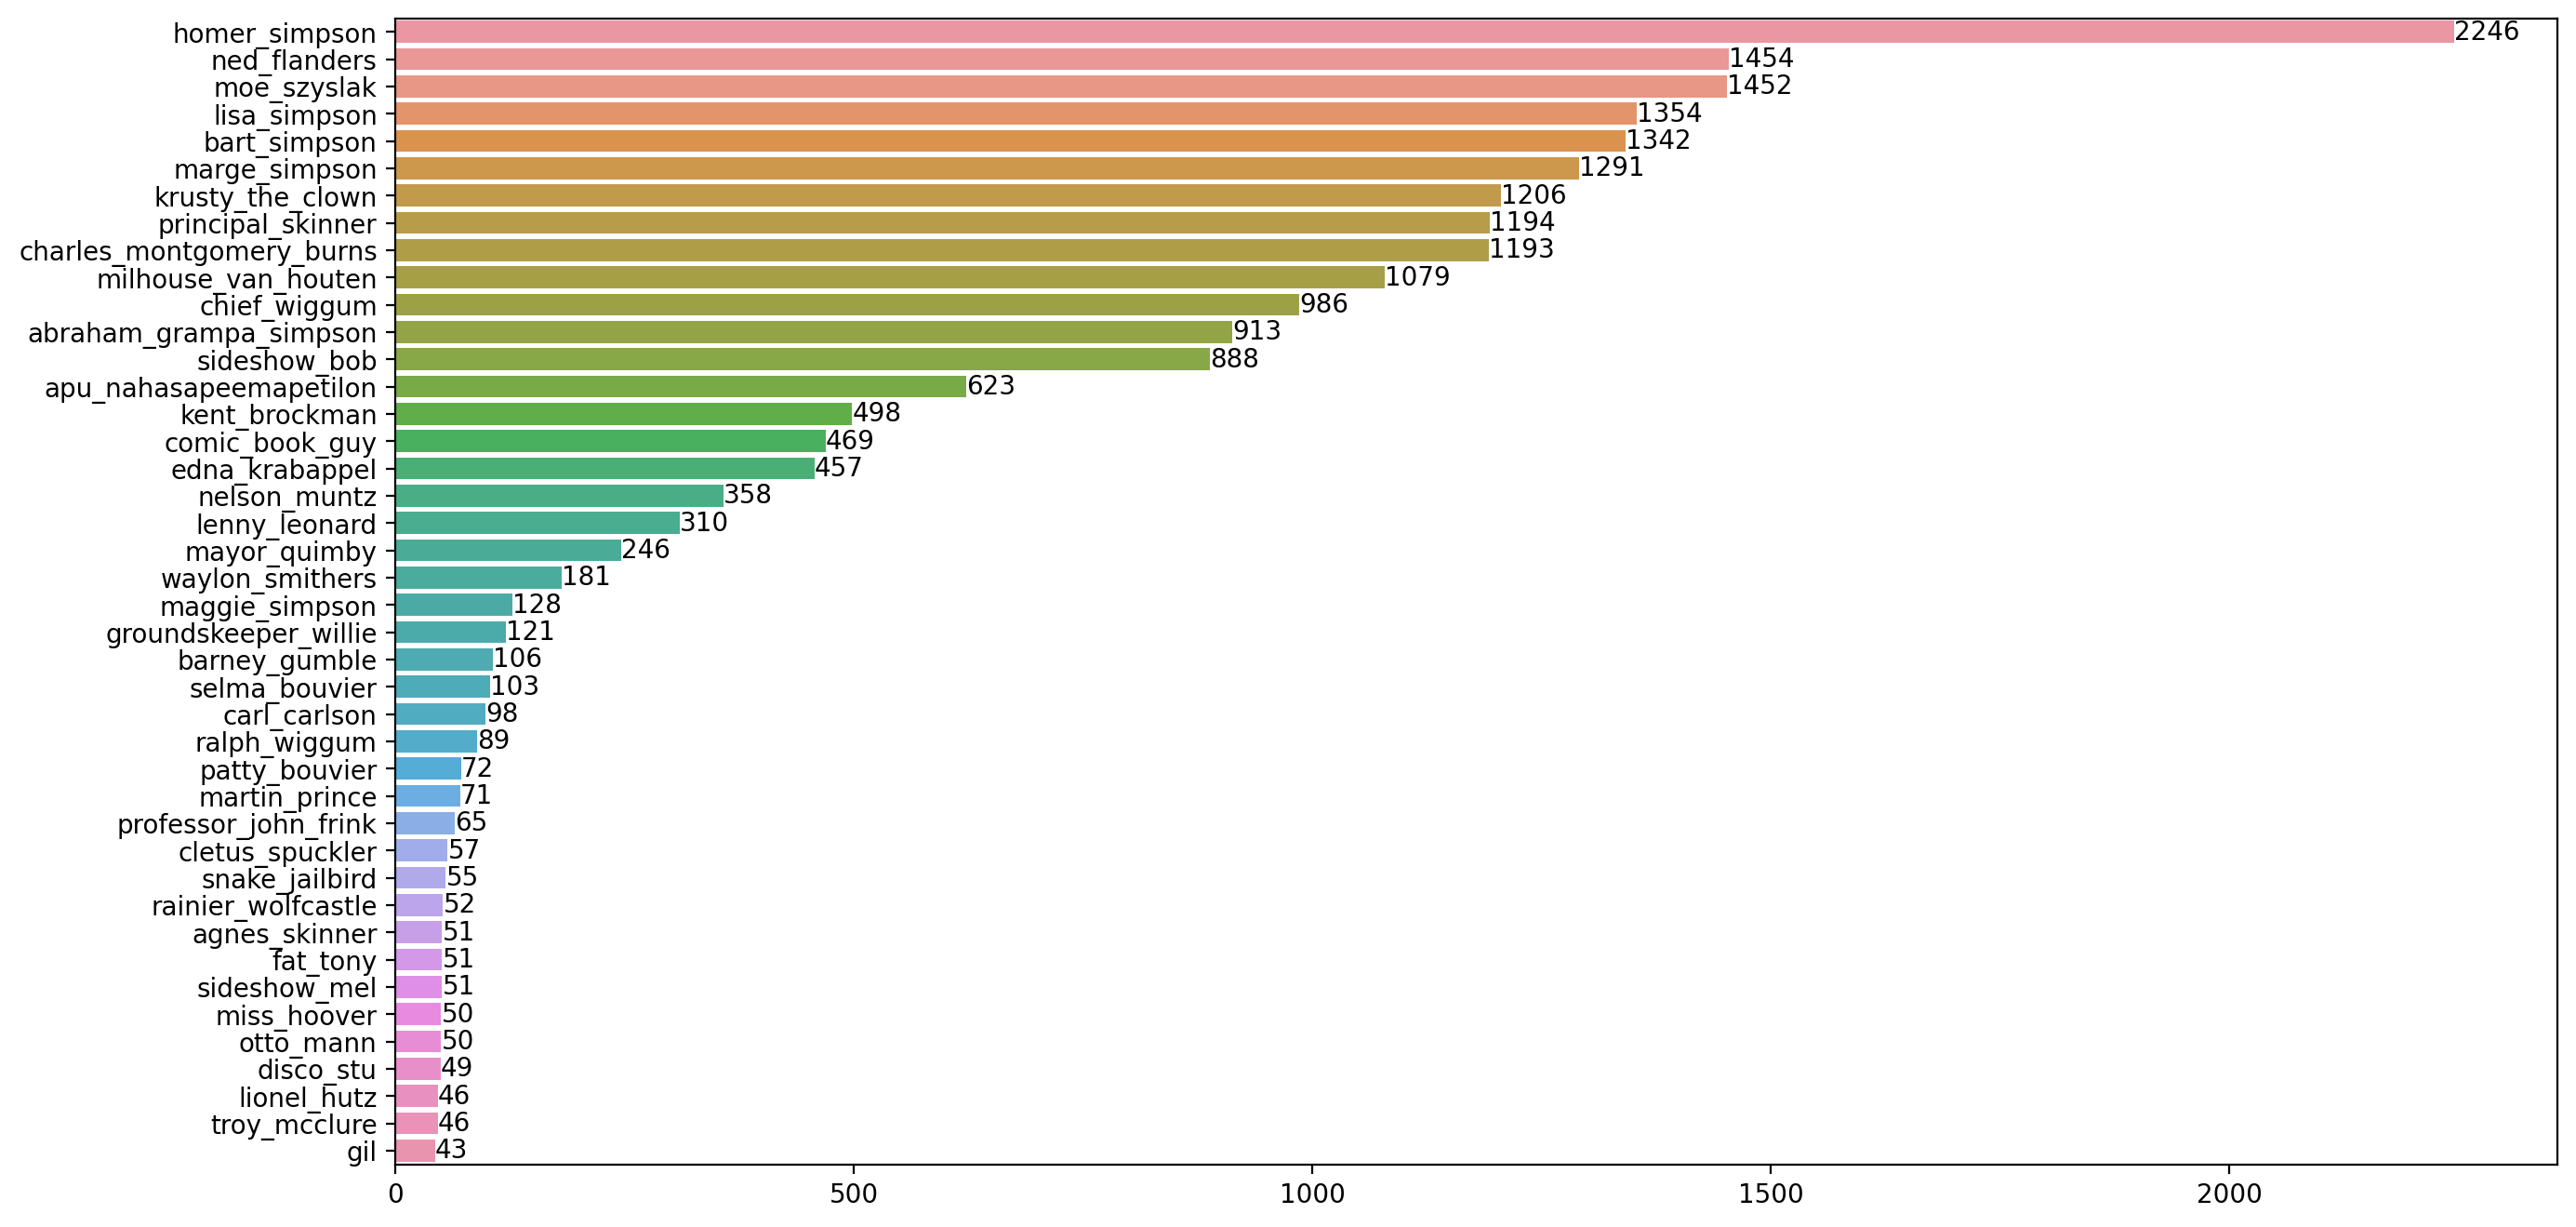

In [31]:
train_val_files = sorted(list(CONFIG['TRAIN_DIR'].glob('*/*.jpg')))
test_files = natsorted(list(CONFIG['TEST_DIR'].glob('*.jpg')))
print(f">>>>> total train and val files: {len(train_val_files)}")
print(f">>>>> total test files: {len(test_files)}")
print(f">> Training on {CONFIG['DEVICE']}")

if CONFIG['DEBUG']:
    # Even for debug we need all 42 persons in dataset, so we can't use np.random.choice(train_val_files)
    
    tmp_lst = [x for x in CONFIG['TRAIN_DIR'].glob('*/') if x.is_dir()]
    train_val_files= []
    image_per_person = 15
    for i in tmp_lst:
        jpg_list = list(Path(i).glob('*.jpg'))
        # check num min examples in list
        if len(jpg_list) > image_per_person:
            train_val_files.extend(np.random.choice(list(Path(i).glob('*.jpg')),image_per_person))
        

train_val_names = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files,
                                          test_size=0.2,
                                          stratify=train_val_names
                                         )

# Datasets
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

# class weights
train_targets = train_dataset.label_encoder.transform(train_dataset.labels)

# Pytorch forum
class_sample_count = np.bincount(train_targets)
weight = 1. / torch.tensor(class_sample_count, dtype=torch.float)
weight = weight.double()
samples_weight = np.array([weight[t] for t in train_targets])
samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()




sampler = WeightedRandomSampler(samples_weight, num_samples=len(train_dataset))

# Dataloaders
train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          pin_memory=True,
                          sampler=sampler
                         )

val_loader = DataLoader(val_dataset,
                        batch_size=CONFIG['BATCH_SIZE'],
                        pin_memory=True,
                        shuffle=False
                       )

test_loader = DataLoader(test_dataset,
                         batch_size=CONFIG['BATCH_SIZE'],

                         pin_memory=True)

# class weights for imbalanced dataset
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_dataset.labels), y=train_dataset.labels)
# class_weights = torch.tensor(class_weights,dtype=torch.float).to(CONFIG['DEVICE'])



 

persons_counter = persons_distribution(train_val_names, plot=True)


## Дисбаланс классов
В датасете наблюдается сильный дисбаланс классов. Это вполне логично, т.к. есть главные персонажи, которые появляются чаще, и эпизодические персонажи. Если оставить датасет в нынешнем виде, наша модель, будет сильно ошибаться на персонажах с небольшим кол-вом картинок в train. 
Для решения такой проблемы мы можем использовать:
1. WeightedRandomSampler - он позволит в каждом батче иметь приблизительно одинаковое количество изображений каждого класса.
2. Вычислить веса каждого класса и передать их в crossentropyloss
3. для классов с критически малым количеством картинок, напарсить новые. 

* В этой же папке есть файл image_scraper, где для персонажей с кол-вом изображений в трейн менее 50 парсятся новые из гугл картинок.


## Let's see pictures from train dataset

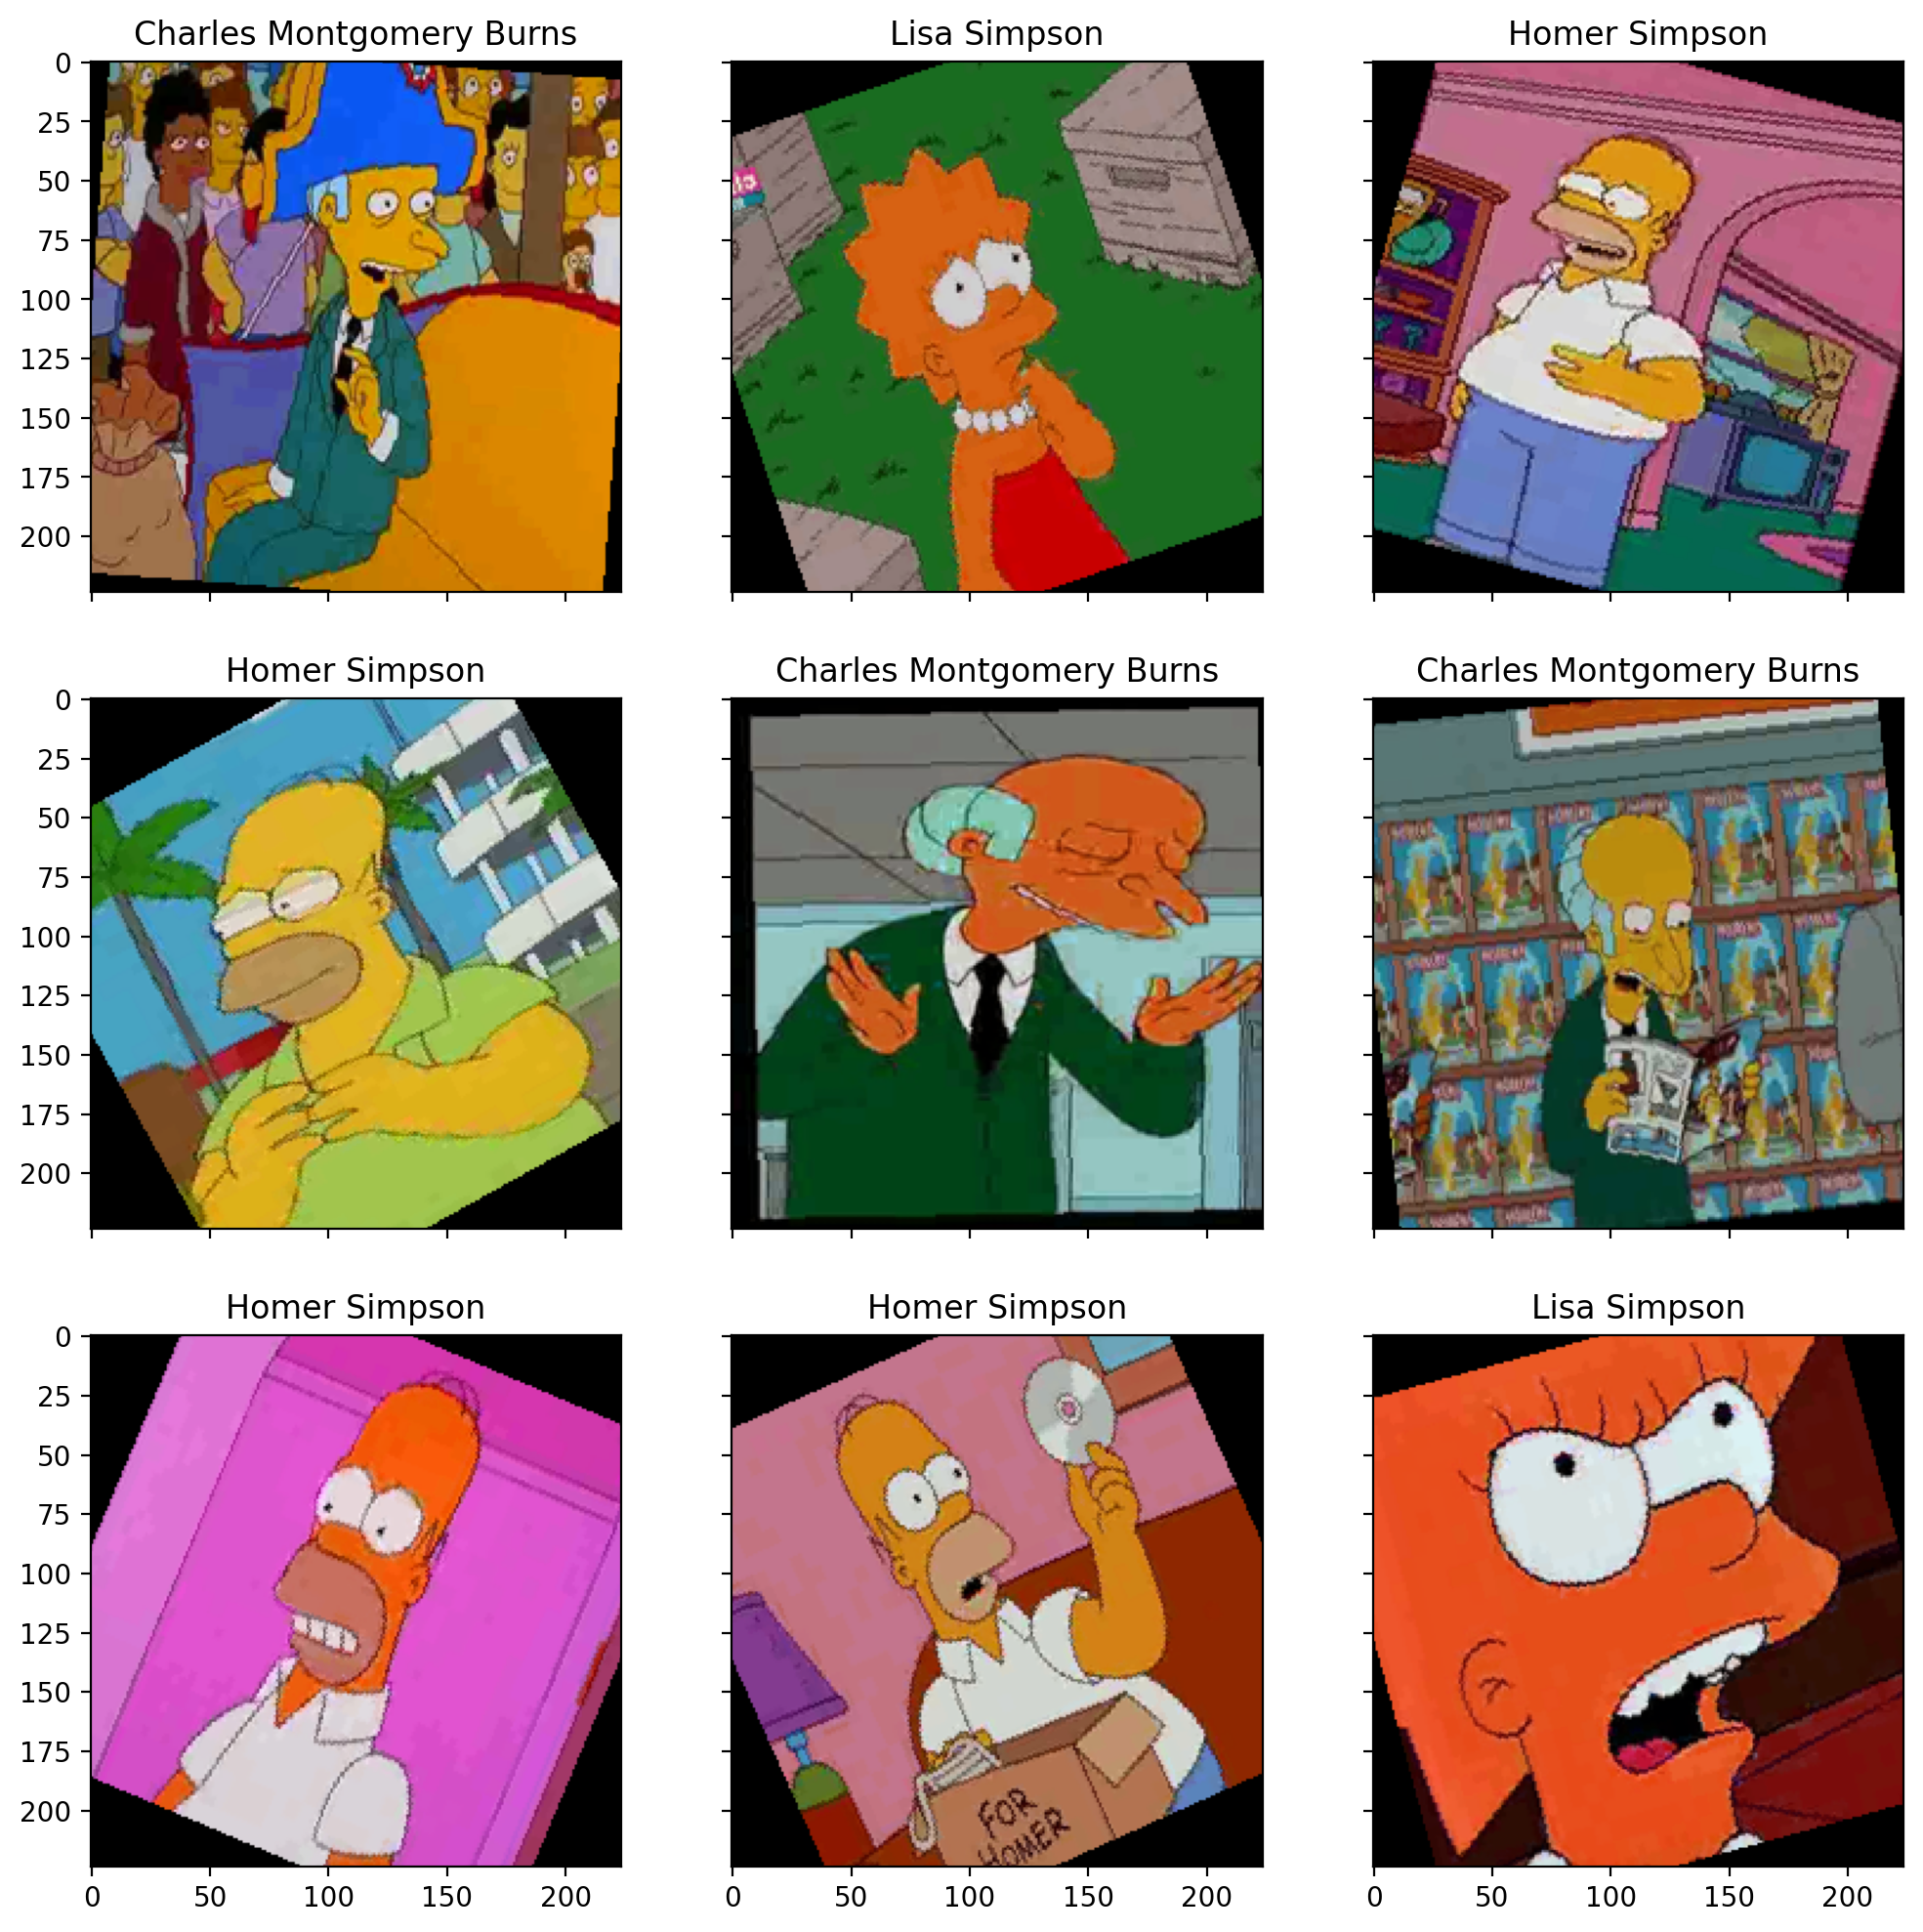

In [8]:
if not CONFIG['DEBUG']:
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), sharey=True, sharex=True)

    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,10000))
        im_val, label = train_dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        imshow(im_val.data.cpu(), \
              title=img_label,plt_ax=fig_x)

In [9]:
# freeze all layers
set_parameter_requires_grad(MODEL, freeze=True)

# ResNext classifier
# in_ftrs = MODEL.fc.in_features
# MODEL.fc = nn.Linear(in_ftrs, CONFIG['NUM_CLASSES'])

# Efficientnet classifier
MODEL.classifier = nn.Sequential(
                                nn.Linear(1792, CONFIG['NUM_CLASSES']))

show_unfreezed_layers(MODEL)

	 classifier.0.weight
	 classifier.0.bias


# Training / feature extraction

In [10]:
MODEL = MODEL.to(CONFIG['DEVICE'])
opt = torch.optim.AdamW(MODEL.parameters(), lr=CONFIG['FEATURE_EXTRACT_LR'])


scheduler = torch.optim.lr_scheduler.StepLR(opt,15, 0.5)
criterion = nn.CrossEntropyLoss()


history, total_true_preds = train(
            train_loader=train_loader,
            val_loader=val_loader,
            model=MODEL,
            epochs=CONFIG['FEATURE_EXTRACT_EPOCHS'],
            batch_size=CONFIG['FEATURE_EXTRACT_BATCH_SIZE'],
            opt=opt,
            scheduler=scheduler,
            criterion=criterion,
            early_stopping=CONFIG['EARLY_STOPPING']
                         )

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

LR: [0.01]


train:   0%|          | 0/67 [00:00<?, ?it/s]

loss 2.1112520160804418 f1 0.49813915478154475


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 001 train_loss: 2.1113     val_loss 1.6098 train_acc 0.5028 val_acc 0.5898     train_f1 0.4981 val_f1 0.6369
LR: [0.01]


train:   0%|          | 0/67 [00:00<?, ?it/s]

loss 1.1544765126912582 f1 0.7196750288410749


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 002 train_loss: 1.1545     val_loss 1.2592 train_acc 0.7227 val_acc 0.6766     train_f1 0.7197 val_f1 0.7040
LR: [0.01]


train:   0%|          | 0/67 [00:00<?, ?it/s]

loss 0.9292100321821181 f1 0.7677916375612471


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.9292     val_loss 1.1938 train_acc 0.7700 val_acc 0.6820     train_f1 0.7678 val_f1 0.7115
LR: [0.01]


train:   0%|          | 0/67 [00:00<?, ?it/s]

loss 0.816180249731367 f1 0.7901270730497156


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.8162     val_loss 1.1051 train_acc 0.7926 val_acc 0.7042     train_f1 0.7901 val_f1 0.7241
LR: [0.01]


train:   0%|          | 0/67 [00:00<?, ?it/s]

loss 0.7472985535833696 f1 0.8099227183590325


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.7473     val_loss 1.0867 train_acc 0.8120 val_acc 0.7063     train_f1 0.8099 val_f1 0.7251
LR: [0.01]


train:   0%|          | 0/67 [00:00<?, ?it/s]

loss 0.6980733914629824 f1 0.8170476456146044


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.6981     val_loss 0.9958 train_acc 0.8188 val_acc 0.7282     train_f1 0.8170 val_f1 0.7440
LR: [0.01]


train:   0%|          | 0/67 [00:00<?, ?it/s]

loss 0.6611080020305787 f1 0.8270319504531154


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.6611     val_loss 0.9858 train_acc 0.8287 val_acc 0.7297     train_f1 0.8270 val_f1 0.7457
LR: [0.01]


train:   0%|          | 0/67 [00:00<?, ?it/s]

loss 0.6426519737381459 f1 0.8305935560358054


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 008 train_loss: 0.6427     val_loss 0.9602 train_acc 0.8321 val_acc 0.7379     train_f1 0.8306 val_f1 0.7522
LR: [0.01]


train:   0%|          | 0/67 [00:00<?, ?it/s]

loss 0.6003959639977298 f1 0.8430780133107754


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 009 train_loss: 0.6004     val_loss 0.9600 train_acc 0.8448 val_acc 0.7337     train_f1 0.8431 val_f1 0.7472
LR: [0.01]


train:   0%|          | 0/67 [00:00<?, ?it/s]

loss 0.582800761709801 f1 0.8479633441066774


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 010 train_loss: 0.5828     val_loss 0.9268 train_acc 0.8494 val_acc 0.7455     train_f1 0.8480 val_f1 0.7569
>>>> saved checkpoint to saved_models/2023-02-03_22-47_efficientnet_b4__epoch10_0.927_(weighted_sampler).pt


In [11]:
# finish feature extracting
wandb.finish()

run_loss,█▆▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▅▆▇▇▇████
train_epoch_acc,▁▅▆▇▇▇████
train_epoch_loss,█▄▃▂▂▂▁▁▁▁
train_f1,▁▅▆▇▇▇████
train_f1_weighted,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▁▅▅▅▅▆▆▆▆▇▇▇▇██▇▇██
val_epoch_loss,█▄▄▃▃▂▂▁▁▁
val_f1,▁▅▅▆▆▇▇█▇█
val_f1_weighted,▁▅▅▆▆▇▇█▇█


# Fine tuning

In [15]:
# Resnext

# MODEL = resnext101_32x8d()

# ResNext classifier
# in_ftrs = MODEL.fc.in_features
# MODEL.fc = nn.Linear(in_ftrs, CONFIG['NUM_CLASSES'])

# opt = torch.optim.AdamW(MODEL.parameters(), lr=CONFIG['LR'])
# set_seed(CONFIG['SEED'])

# MODEL, opt = load_checkpoint(MODEL, opt)
# MODEL = MODEL.to('mps')

In [3]:
set_parameter_requires_grad(MODEL, freeze=True)
set_parameter_requires_grad(MODEL.layer4[2])
set_parameter_requires_grad(MODEL.fc)
show_unfreezed_layers(MODEL)

	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 layer4.2.conv3.weight
	 layer4.2.bn3.weight
	 layer4.2.bn3.bias
	 fc.weight
	 fc.bias


In [27]:
# efficientnet b4
MODEL = efficientnet_b4()
MODEL.classifier = nn.Sequential(
                                nn.Linear(1792, CONFIG['NUM_CLASSES']))

# Efficientnet classifier
MODEL, _ = load_checkpoint(MODEL, opt)

set_parameter_requires_grad(MODEL, freeze=True)
set_parameter_requires_grad(MODEL.features[8])
set_parameter_requires_grad(MODEL.classifier)

show_unfreezed_layers(MODEL)
set_seed(CONFIG['SEED'])

MODEL = MODEL.to(CONFIG['DEVICE'])

load checkpoint from saved_models/2023-02-03_22-47_efficientnet_b4__epoch10_0.927_(weighted_sampler).pt
	 features.8.0.weight
	 features.8.1.weight
	 features.8.1.bias
	 classifier.0.weight
	 classifier.0.bias


In [12]:
# Efficientnet b4
# # opt = torch.optim.AdamW(MODEL.parameters())
# MODEL, opt, _,_ = load_checkpoint(MODEL, opt)
# # MODEL.train()

# # freeze all layers
# set_parameter_requires_grad(MODEL, feature_extracting=True)
# # unfreeze lastst layer
# for param in MODEL.features[8:].parameters():
#     param.requires_grad = True
# # unfreeze classifier
# MODEL.classifier = nn.Sequential(nn.Linear(1792, CONFIG['NUM_CLASSES']))
# MODEL.to(CONFIG['DEVICE'])

# show_unfreezed_layers(MODEL)


In [32]:
wandb.init(project=CONFIG['PROJECT_NAME'], name=CONFIG['MODEL_NAME'] + "_finetune")

In [33]:
opt = torch.optim.AdamW(MODEL.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(opt, 10, CONFIG['LR'])
criterion = nn.CrossEntropyLoss()

In [34]:

history_ft, true_preds_ft = train(train_loader,
                                 val_loader,
                                 MODEL,
                                  epochs=CONFIG['EPOCHS'],
                                  batch_size=CONFIG['BATCH_SIZE'],
                                  opt=opt,
                                  scheduler=scheduler,
                                  criterion=criterion,
                                  early_stopping=CONFIG['EARLY_STOPPING']
                                 )

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

LR: [0.001]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.7771021019494909 f1 0.788970352688026


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 001 train_loss: 0.7771     val_loss 0.7228 train_acc 0.7899 val_acc 0.8023     train_f1 0.7890 val_f1 0.8109
LR: [0.001]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.5286906304488805 f1 0.8570673701889288


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.5287     val_loss 0.6785 train_acc 0.8580 val_acc 0.8132     train_f1 0.8571 val_f1 0.8207
LR: [0.001]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.4460033404285737 f1 0.8779386757454454


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.4460     val_loss 0.6338 train_acc 0.8786 val_acc 0.8273     train_f1 0.8779 val_f1 0.8315
LR: [0.001]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.41506111764232867 f1 0.88717113830228


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.4151     val_loss 0.5855 train_acc 0.8878 val_acc 0.8419     train_f1 0.8872 val_f1 0.8472
LR: [0.001]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.36439365958067144 f1 0.897922374912568


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.3644     val_loss 0.5588 train_acc 0.8986 val_acc 0.8431     train_f1 0.8979 val_f1 0.8471
LR: [0.001]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.3528640881185158 f1 0.9037862066026995


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.3529     val_loss 0.5550 train_acc 0.9042 val_acc 0.8485     train_f1 0.9038 val_f1 0.8521
LR: [0.001]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.324193685515656 f1 0.9091246372846399


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.3242     val_loss 0.5441 train_acc 0.9096 val_acc 0.8528     train_f1 0.9091 val_f1 0.8563
LR: [0.001]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.3160138161273454 f1 0.9150609739923515


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 008 train_loss: 0.3160     val_loss 0.5259 train_acc 0.9156 val_acc 0.8608     train_f1 0.9151 val_f1 0.8630
LR: [0.001]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2845130728685691 f1 0.9213881139567167


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 009 train_loss: 0.2845     val_loss 0.5054 train_acc 0.9218 val_acc 0.8611     train_f1 0.9214 val_f1 0.8636
LR: [0.001]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2715840284160301 f1 0.9274440210891778


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 010 train_loss: 0.2716     val_loss 0.5109 train_acc 0.9278 val_acc 0.8613     train_f1 0.9274 val_f1 0.8633
>>>> saved checkpoint to saved_models/2023-02-04_01-11_efficientnet_b4__epoch10_0.511_(weighted_sampler).pt
>>>> saved checkpoint to saved_models/2023-02-04_01-11_efficientnet_b4__epoch10_0.511_(weighted_sampler).pt
Early stopping counter: 1
LR: [1e-05]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2611090136555155 f1 0.9313761422889054


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 011 train_loss: 0.2611     val_loss 0.8129 train_acc 0.9318 val_acc 0.8087     train_f1 0.9314 val_f1 0.7980
>>>> saved checkpoint to saved_models/2023-02-04_01-23_efficientnet_b4__epoch11_0.813_(weighted_sampler).pt
Early stopping counter: 2
LR: [1e-05]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2557970130999016 f1 0.9311336002524941


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 012 train_loss: 0.2558     val_loss 0.5051 train_acc 0.9315 val_acc 0.8629     train_f1 0.9311 val_f1 0.8649
LR: [1e-05]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2523016394010795 f1 0.9292476259768541


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 013 train_loss: 0.2523     val_loss 0.5024 train_acc 0.9298 val_acc 0.8651     train_f1 0.9292 val_f1 0.8670
LR: [1e-05]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.25707944571374264 f1 0.9284356676640739


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 014 train_loss: 0.2571     val_loss 0.5005 train_acc 0.9289 val_acc 0.8651     train_f1 0.9284 val_f1 0.8670
LR: [1e-05]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.25490094519617706 f1 0.9277883484442985


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 015 train_loss: 0.2549     val_loss 0.4997 train_acc 0.9281 val_acc 0.8648     train_f1 0.9278 val_f1 0.8667
LR: [1e-05]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2531310904767794 f1 0.932779094372888


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 016 train_loss: 0.2531     val_loss 0.4983 train_acc 0.9332 val_acc 0.8658     train_f1 0.9328 val_f1 0.8678
LR: [1e-05]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2604097358598993 f1 0.9290191487416922


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 017 train_loss: 0.2604     val_loss 0.7921 train_acc 0.9294 val_acc 0.8134     train_f1 0.9290 val_f1 0.8011
>>>> saved checkpoint to saved_models/2023-02-04_02-24_efficientnet_b4__epoch17_0.792_(weighted_sampler).pt
Early stopping counter: 1
LR: [1e-05]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2521241471993118 f1 0.9314369274753632


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 018 train_loss: 0.2521     val_loss 0.4954 train_acc 0.9318 val_acc 0.8655     train_f1 0.9314 val_f1 0.8675
LR: [1e-05]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2561052635421939 f1 0.9315407932571305


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 019 train_loss: 0.2561     val_loss 0.4950 train_acc 0.9318 val_acc 0.8653     train_f1 0.9315 val_f1 0.8672
LR: [1e-05]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2700445823887744 f1 0.9266926939390795


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 020 train_loss: 0.2700     val_loss 0.4941 train_acc 0.9270 val_acc 0.8651     train_f1 0.9267 val_f1 0.8668
>>>> saved checkpoint to saved_models/2023-02-04_02-55_efficientnet_b4__epoch20_0.494_(weighted_sampler).pt
LR: [1.0000000000000001e-07]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2586206386246466 f1 0.9290161933482486


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 021 train_loss: 0.2586     val_loss 0.4941 train_acc 0.9293 val_acc 0.8651     train_f1 0.9290 val_f1 0.8668
LR: [1.0000000000000001e-07]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.25108977843266045 f1 0.9306190310610063


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 022 train_loss: 0.2511     val_loss 0.4941 train_acc 0.9309 val_acc 0.8651     train_f1 0.9306 val_f1 0.8668
>>>> saved checkpoint to saved_models/2023-02-04_03-18_efficientnet_b4__epoch22_0.494_(weighted_sampler).pt
Early stopping counter: 1
LR: [1.0000000000000001e-07]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.25220241093312135 f1 0.9301493607256581


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 023 train_loss: 0.2522     val_loss 0.4941 train_acc 0.9305 val_acc 0.8651     train_f1 0.9301 val_f1 0.8668
LR: [1.0000000000000001e-07]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2634513395035102 f1 0.9294110237432059


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 024 train_loss: 0.2635     val_loss 0.4941 train_acc 0.9297 val_acc 0.8651     train_f1 0.9294 val_f1 0.8668
LR: [1.0000000000000001e-07]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2645769255891095 f1 0.9294801697091248


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 025 train_loss: 0.2646     val_loss 0.4940 train_acc 0.9298 val_acc 0.8651     train_f1 0.9295 val_f1 0.8668
LR: [1.0000000000000001e-07]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.26274144762879237 f1 0.9280151334711483


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 026 train_loss: 0.2627     val_loss 0.4940 train_acc 0.9285 val_acc 0.8651     train_f1 0.9280 val_f1 0.8668
LR: [1.0000000000000001e-07]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.24992683362869414 f1 0.9325028090197366


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 027 train_loss: 0.2499     val_loss 0.4940 train_acc 0.9329 val_acc 0.8651     train_f1 0.9325 val_f1 0.8668
LR: [1.0000000000000001e-07]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2609355492644238 f1 0.9301724848840475


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 028 train_loss: 0.2609     val_loss 0.4940 train_acc 0.9306 val_acc 0.8651     train_f1 0.9302 val_f1 0.8668
LR: [1.0000000000000001e-07]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.25960118794460557 f1 0.9275422395593763


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 029 train_loss: 0.2596     val_loss 0.4940 train_acc 0.9277 val_acc 0.8651     train_f1 0.9275 val_f1 0.8668
LR: [1.0000000000000001e-07]


train:   0%|          | 0/133 [00:00<?, ?it/s]

loss 0.2668067281496135 f1 0.9252464904404559


val:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 030 train_loss: 0.2668     val_loss 0.4940 train_acc 0.9257 val_acc 0.8651     train_f1 0.9252 val_f1 0.8668
>>>> saved checkpoint to saved_models/2023-02-04_04-34_efficientnet_b4__epoch30_0.494_(weighted_sampler).pt


# Classification report

In [35]:
names_true = train_dataset.label_encoder.inverse_transform(true_preds_ft['true'])
names_preds = train_dataset.label_encoder.inverse_transform(true_preds_ft['preds'])
rep = pd.DataFrame(classification_report(names_true, names_preds, output_dict=True)).T
rep  = rep.sort_values(by='f1-score', ascending=False)
rep_filename = f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')}_{CONFIG['MODEL_NAME']}.csv"
rep.to_csv(rep_filename)

In [36]:
rep

,precision,recall,f1-score,support
sideshow_bob,0.953276,0.939888,0.946535,5340.000000
kent_brockman,0.922756,0.959667,0.940850,3000.000000
lionel_hutz,0.987395,0.870370,0.925197,270.000000
krusty_the_clown,0.925786,0.883402,0.904098,7230.000000
disco_stu,0.897351,0.903333,0.900332,300.000000
apu_nahasapeemapetilon,0.924759,0.868533,0.895765,3750.000000
chief_wiggum,0.903531,0.887479,0.895433,5910.000000
edna_krabappel,0.856549,0.905495,0.880342,2730.000000
bart_simpson,0.879388,0.872388,0.875874,8040.000000
lisa_simpson,0.879289,0.869988,0.874614,8130.000000


In [5]:
loss_df = pd.read_csv('data/loss.csv')
f1_df = pd.read_csv('data/f1.csv')

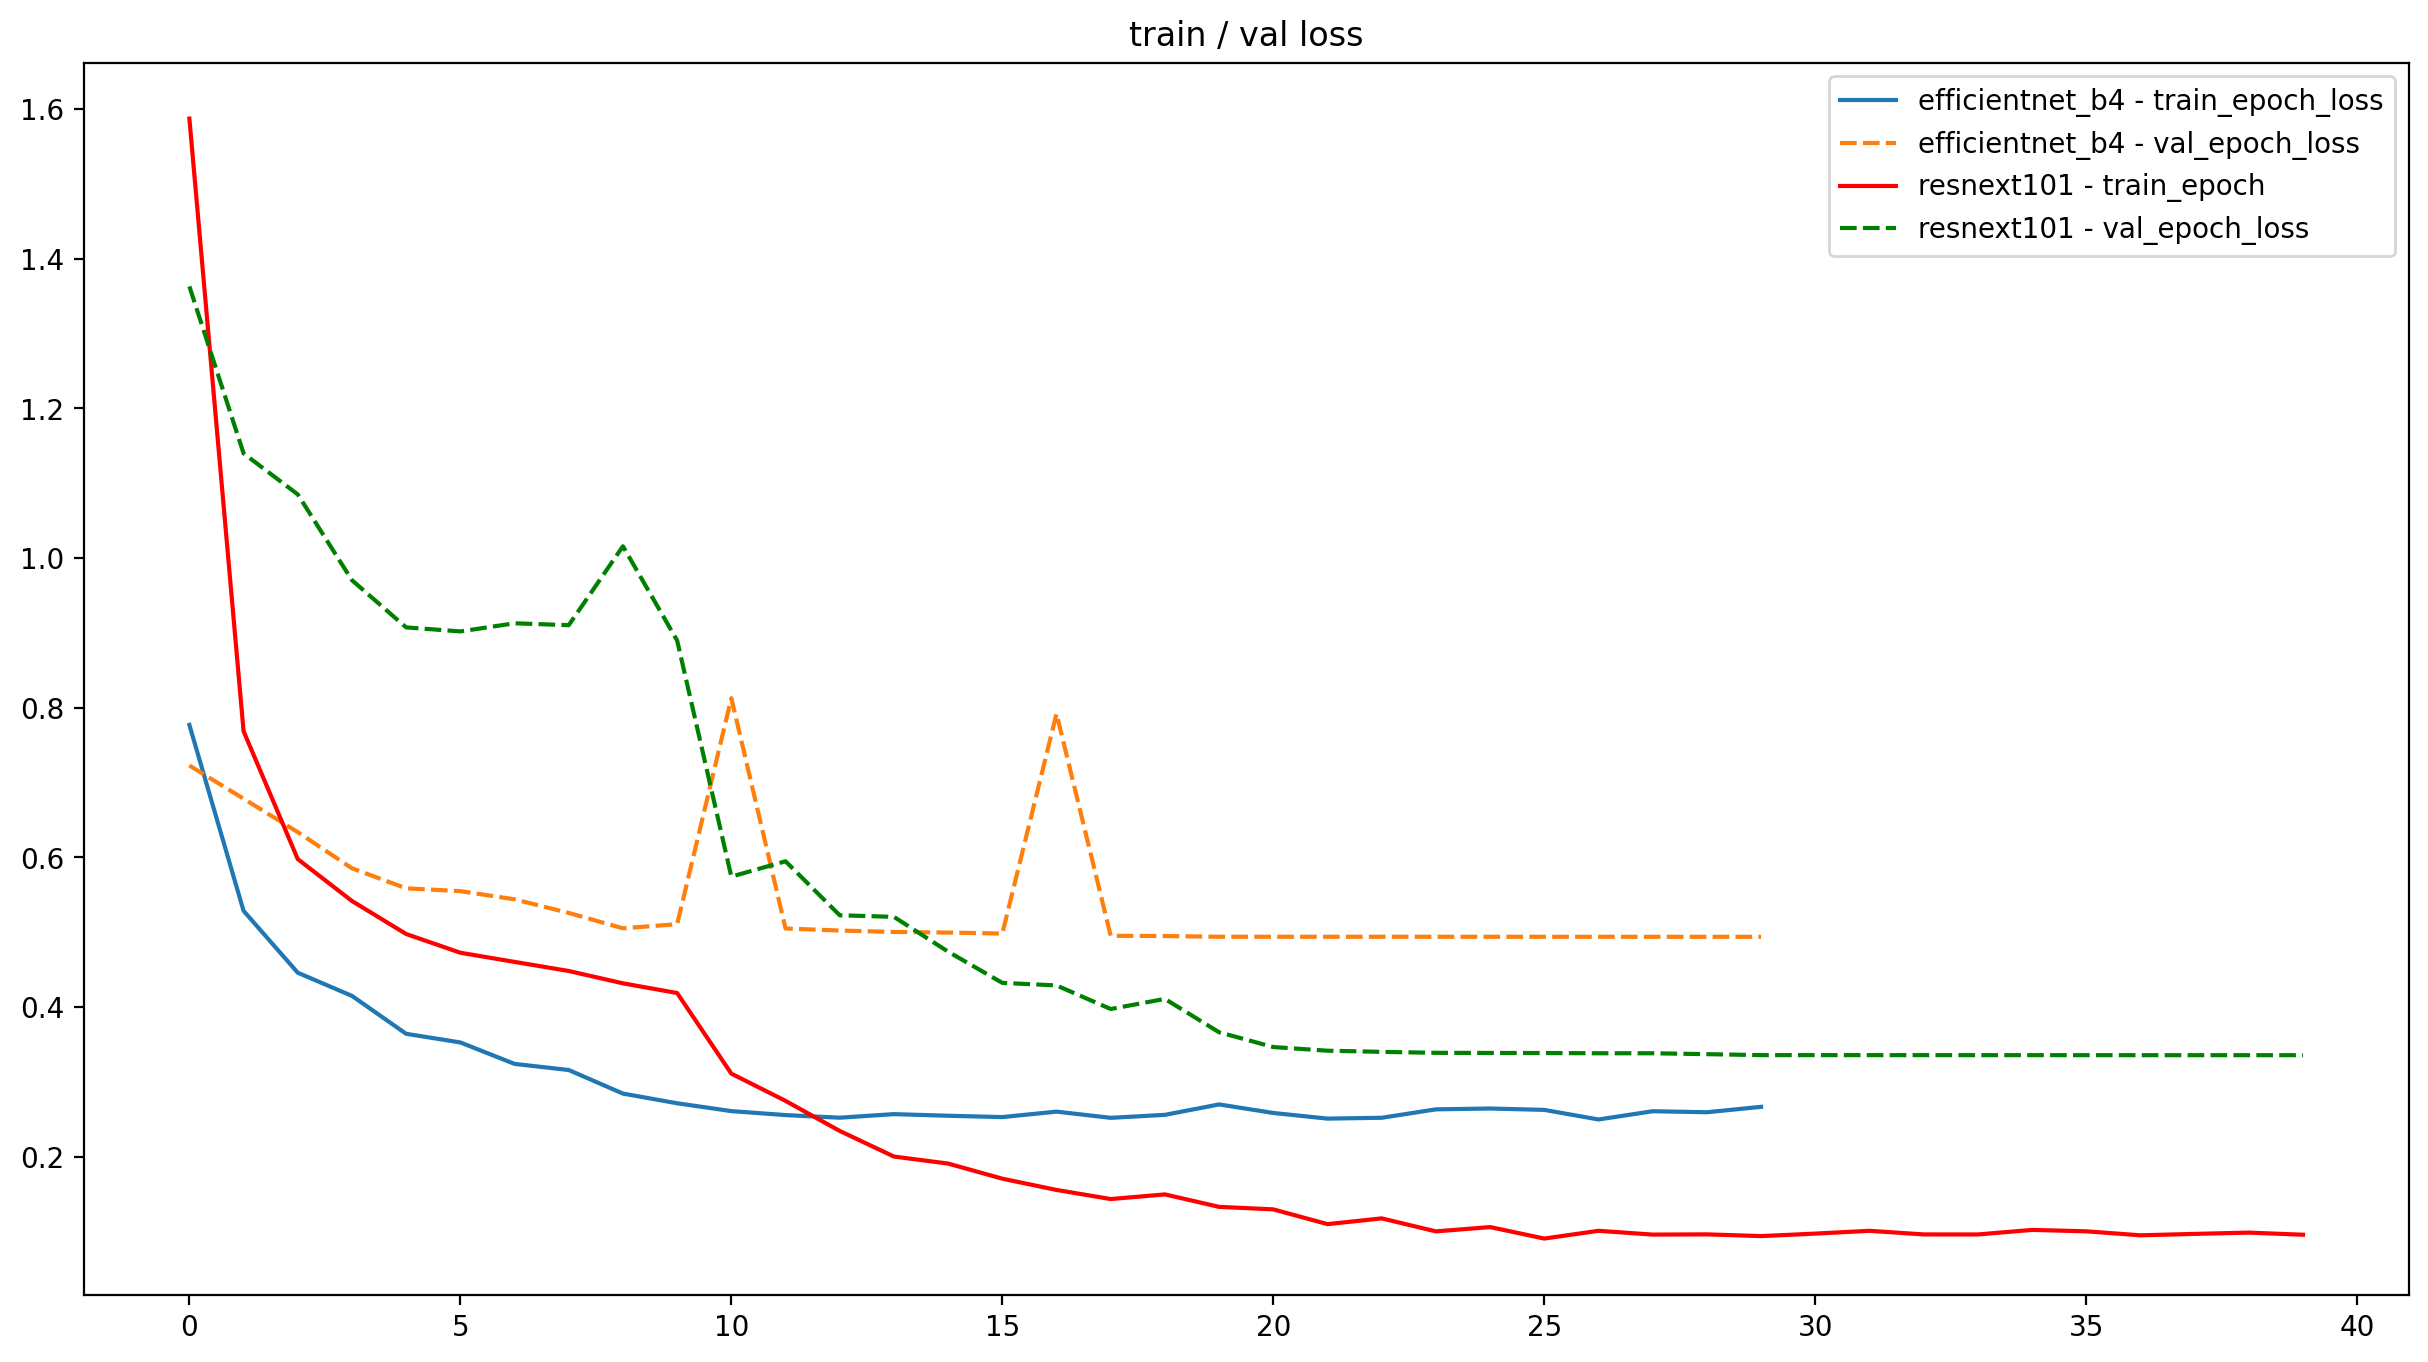

In [6]:
plt.figure(figsize=(15,8))
plt.title('train / val loss')
sns.lineplot(data=loss_df.iloc[:,:2]);
sns.lineplot(data=loss_df.iloc[:,2:], palette=['r','g']);

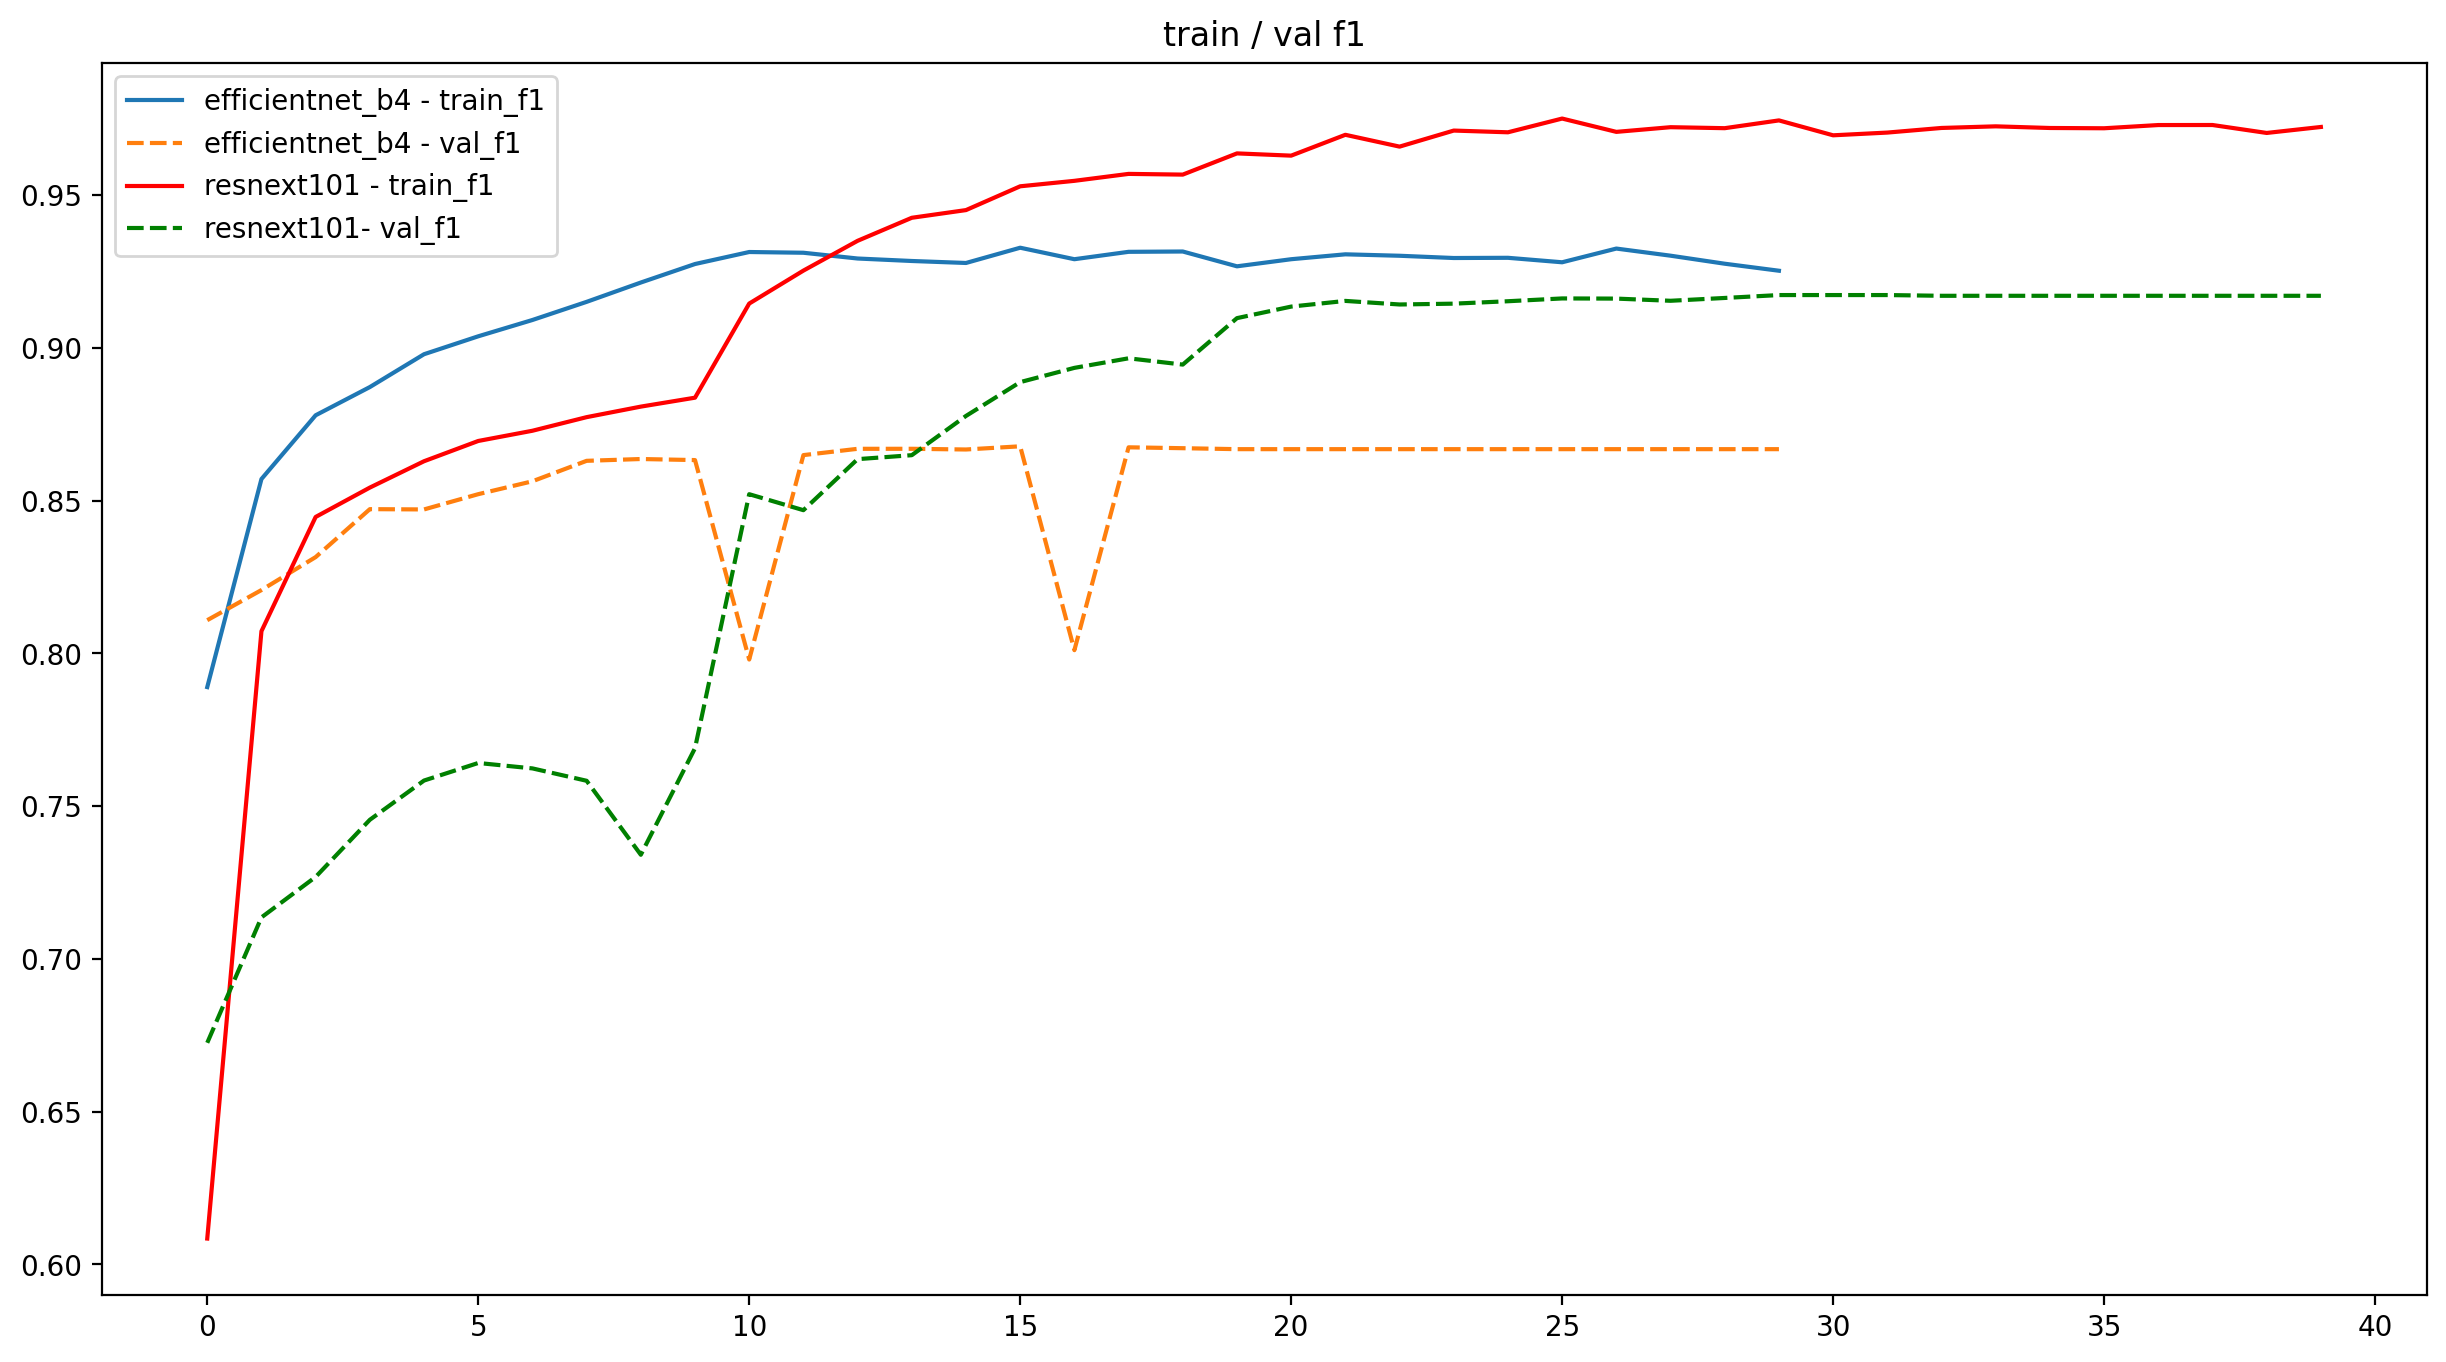

In [7]:
plt.figure(figsize=(15,8))
plt.title('train / val f1')
sns.lineplot(data=f1_df.iloc[:,:2])
sns.lineplot(data=f1_df.iloc[:,2:], palette=['r','g']);

In [18]:
loss_df['resnext101 - val_epoch_loss'].min()

0.3358228448483988

# Prediction

In [15]:
test_probs = predict(MODEL, test_loader)
y_pred = np.argmax(test_probs, -1)
le = pickle.load(open('label_encoder.pkl', 'rb'))

  0%|          | 0/8 [00:00<?, ?it/s]

### Submit на Kaggle

In [14]:
submit = pd.read_csv('sample_submission.csv')
submit['Expected'] = le.inverse_transform(y_pred)

submit.to_csv('submit.csv', index=False)

![alt text](kaggle_submit.png "Kaggle submit")